In [26]:
import numpy as np
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.api import OLS
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
import geopandas as gp

In [33]:
def Get_FIPS(df, state):
    """
    df: DataFrame
    state: U.S. State Name (e.g. California, Idaho, etc.)
    
    Returns 2-Dimensional Numpy array of U.S. States' Counties and FIPS Codes.
    """
    
    state_df = df[df['state'] == state]
    fips_array = state_df['FIPS'].unique()
    
    return fips_array

def County_Winners(df, state):
    """
    df: DataFrame
    state: U.S. State Name (e.g. California, Idaho, etc.)
    
    Returns 
    """
    
    state_df = df[df['state'] == state]
    election_years = state_df['year'].unique()
    winners_container = [[] for _ in range(len(election_years))]
    
    for idx, year in enumerate(election_years):
        winners = state_df[state_df['year'] == year].groupby('FIPS').apply(
            lambda county: county['party'][county['candidatevotes'].idxmax()]).values
        winners_container[idx] = winners
    
    return winners_container

def County_Winners_DF(df):
    """
    df: 
    
    Returns 
    """
    states = df['state'].unique()
    list_counties, list_fips = [], []
    list_2000, list_2004 = [], []
    list_2008, list_2012 = [], []
    list_2016 = []
    
    for state in states:
        fips = Get_FIPS(df=df, state=state)
        county_winners = County_Winners(df=df, state=state)
        list_fips.extend(fips)
        list_2000.extend(county_winners[0])
        list_2004.extend(county_winners[1])
        list_2008.extend(county_winners[2])
        list_2012.extend(county_winners[3])
        list_2016.extend(county_winners[4])
    
    final_dataframe = pd.DataFrame({
    'countyFIPS': list_fips,
    '2000': list_2000, '2004': list_2004, 
    '2008': list_2008, '2012': list_2012,
    '2016': list_2016})
    
    final_dataframe.replace({'republican': 1, 'democrat': 0}, inplace=True)
    final_dataframe['Total'] = final_dataframe.loc[:, ('2000', '2004', '2008', '2012', '2016')].sum(axis=1)
    
    return final_dataframe

---

## County Pres. 2000 - 2016

In [34]:
abridged = pd.read_csv('abridged_couties.csv')
county_pres_df = pd.read_csv('countypres_2000-2016.csv')
county_pres_df = county_pres_df[(county_pres_df['party'] == 'democrat') | (county_pres_df['party'] == 'republican')]
county_pres_df.dropna(inplace=True)
county_pres_df = county_pres_df[(county_pres_df['county'] != 'Broomfield') & 
                                (county_pres_df['county'] != 'Kansas City') &
                                (county_pres_df['county'] != 'Bedford')]

In [35]:
county_winners_df = County_Winners_DF(county_pres_df)

In [40]:
abridged['countyFIPS'] = abridged['countyFIPS'][:-2].astype(int, copy=False)
merged = abridged.merge(cwdf, on='countyFIPS', how='inner')

In [41]:
cols = ['stay at home', '>50 gatherings', '>500 gatherings', 'public schools', 
        'restaurant dine-in', 'entertainment/gym', 'Total'] # columns of interest

merged_narrowed = merged.loc[:, cols]
merged_narrowed.dropna(inplace=True)

In [42]:
model = LinearRegression()
model.fit(o.iloc[:, :-1], o.iloc[:, -1])
model.score(o.iloc[:, :-1], o.iloc[:, -1])

0.03742488704282565

In [61]:
merged_narrowed.iloc[:, :-1].columns.tolist()

['stay at home',
 '>50 gatherings',
 '>500 gatherings',
 'public schools',
 'restaurant dine-in',
 'entertainment/gym']

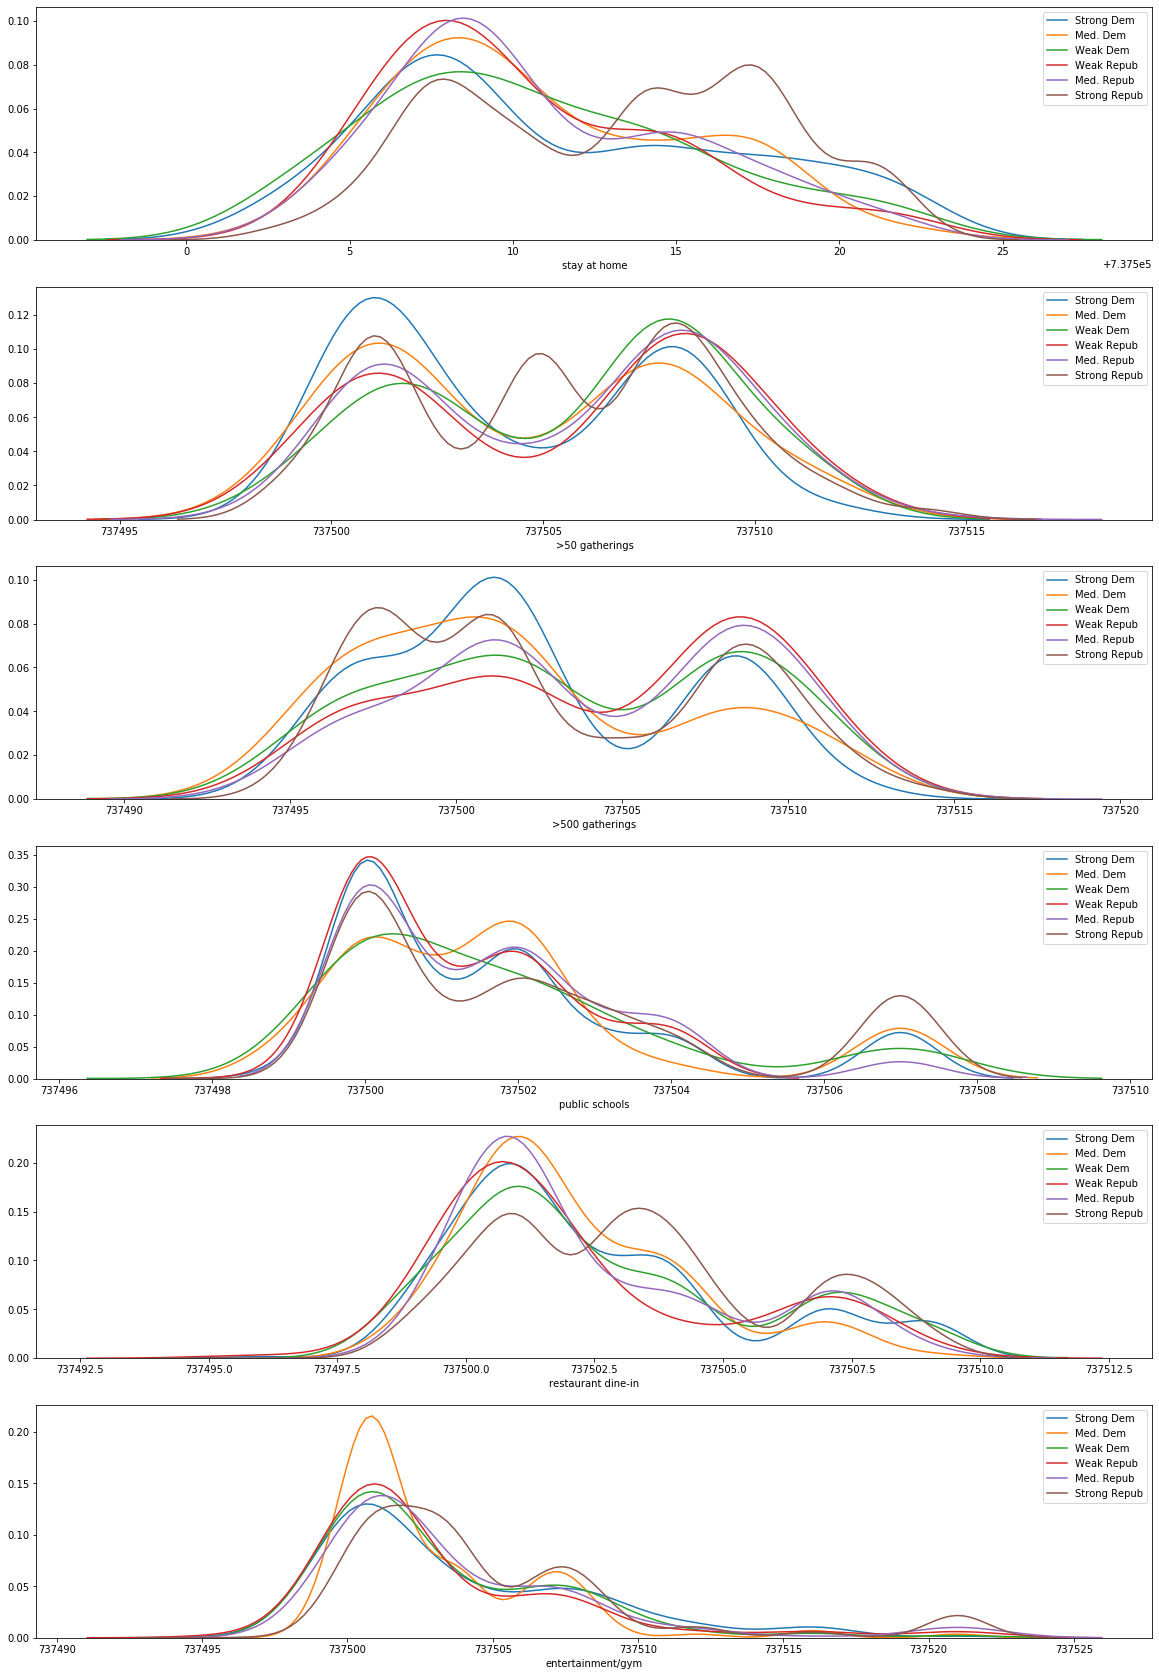

In [110]:
fig, axes = plt.subplots(6, 1, figsize=(20,5*6))
columns = merged_narrowed.iloc[:, :-1].columns.tolist()

for ax_position, column in enumerate(columns):
    sns.distplot(merged_narrowed[merged_narrowed['Total'] == 0].loc[:,column], hist=False, label='Strong Dem', ax=axes[ax_position])
    sns.distplot(merged_narrowed[merged_narrowed['Total'] == 1].loc[:,column], hist=False, label='Med. Dem', ax=axes[ax_position])
    sns.distplot(merged_narrowed[merged_narrowed['Total'] == 2].loc[:,column], hist=False, label='Weak Dem', ax=axes[ax_position])
    sns.distplot(merged_narrowed[merged_narrowed['Total'] == 3].loc[:,column], hist=False, label='Weak Repub', ax=axes[ax_position])
    sns.distplot(merged_narrowed[merged_narrowed['Total'] == 4].loc[:,column], hist=False, label='Med. Repub', ax=axes[ax_position])
    sns.distplot(merged_narrowed[merged_narrowed['Total'] == 5].loc[:,column], hist=False, label='Strong Repub', ax=axes[ax_position])
    
plt.legend();

In [111]:
shape = gp.read_file('cb_2018_us_county_5m/cb_2018_us_county_5m.shp')
shape = shape.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')]
shape['STATEFP'] = shape['STATEFP'].astype(float)
shape['COUNTYFP'] = shape['COUNTYFP'].astype(float)

DriverError: cb_2018_us_county_5m/cb_2018_us_county_5m.shp: No such file or directory

In [1228]:
merged_shape = shape.loc[:, ('STATEFP', 'COUNTYFP', 'geometry')].merge(merged.loc[:, ('Total', 'STATEFP', 'COUNTYFP')], 
                                                            on=['STATEFP', 'COUNTYFP']).loc[:, ('Total', 'geometry')]
merged_shape = merged_shape.cx[-130:-50, 20:]

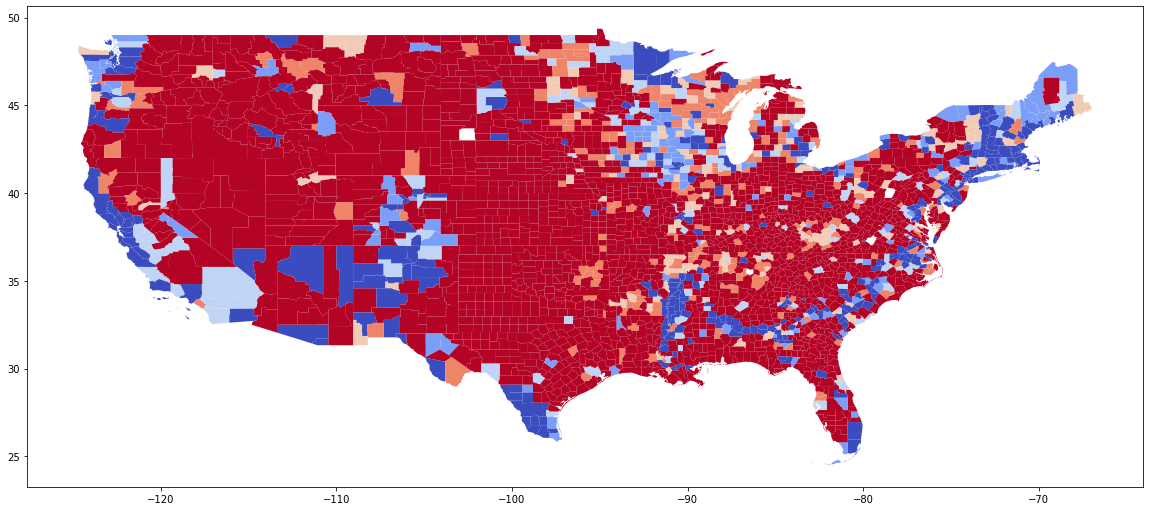

In [1229]:
merged_shape.plot(column='Total', cmap='coolwarm', figsize=(20,10), linewidth=0, edgecolor='white');

----

### Google Mobility Report

In [1048]:
mob = pd.read_csv('Global_Mobility_Report.csv')
mob = mob[mob['country_region'] == 'United States']
mob.head()

,country_region_code,country_region,sub_region_1,sub_region_2,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
87589,US,United States,NaN,NaN,2020-02-15,6.0,2.0,15.0,3.0,2.0,-1.0
87590,US,United States,NaN,NaN,2020-02-16,7.0,1.0,16.0,2.0,0.0,-1.0
87591,US,United States,NaN,NaN,2020-02-17,6.0,0.0,28.0,-9.0,-24.0,5.0
87592,US,United States,NaN,NaN,2020-02-18,0.0,-1.0,6.0,1.0,0.0,1.0
87593,US,United States,NaN,NaN,2020-02-19,2.0,0.0,8.0,1.0,1.0,0.0
